# Read Tr=2 case

1. Read only points from `.POST` files which are internally H5.
2. query the following points:

In [7]:
import os
import h5py
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

# Define the data folder - must include .h5 cas and dat files.
#data_folder = r"D:\2024 - Thermal Amplifiers - KC\Tr=1.1\Lauren\\"
data_folder = r"E:\TR_1.3\\"
#data_folder = r"E:\L5\\"

#from cmcrameri import cm

In [9]:
# Check if NodeX is not defined
if 'NodeX' not in globals():
    # Find .cas.post files
    case_files = [f for f in os.listdir(data_folder) if f.endswith('.cas.post')]
    
    if case_files:
        fname = os.path.join(data_folder, case_files[0])
        
        # Read the mesh data from the HDF5 file
        with h5py.File(fname, 'r') as f:
            vertex_list = np.transpose(f['/meshes/1.post/nodes/coords/1'][:])
        
        # Extract NodeX and NodeY
        node_x = vertex_list[0]
        node_y = vertex_list[1]
    
    # Clean up variables
    del case_files

# Define constants
tw = 308
yw = -0.015

# Find *dat.post files
data_files = [data_folder+f for f in os.listdir(data_folder) if f.endswith('.dat.post')]

def get_time(data_file):
    #return float(data_file.split(".")[0].split("-")[-1])  #My directories
    return float(data_file.split(".")[1].split("-")[-1])  #works with the main KC directory + Grace's 

data_files = sorted(data_files, key=get_time)


timestep = 5000
fname = os.path.join(data_folder, data_files[timestep])

# Read temperature and velocity data from the HDF5 file
with h5py.File(fname, 'r') as f:
    T = f['/results/1.post/mixture/nodes/Static Temperature/1'][:]
    U = f['/results/1.post/mixture/nodes/X Velocity/1'][:]
    V = f['/results/1.post/mixture/nodes/Y Velocity/1'][:]


In [10]:
len(data_files)

15000

Plot the nodes with U,V,T

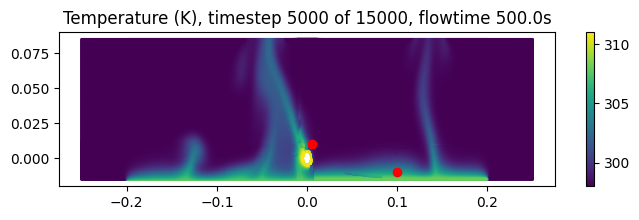

In [11]:
# Proof that they are mapped properly
fig, ax = plt.subplots(figsize=(8,2))
im = ax.scatter(node_x, node_y, c=T, cmap='viridis', s=1)
ax.set_title("Temperature (K), timestep {} of {}, flowtime {}s".format(timestep, len(data_files), timestep*0.05*2))

ax.scatter([0.1, 0.005], [-0.01, 0.01], color='r')

plt.colorbar(im)

In [12]:
print(max(T))

311.00000000000006


Text(0.5, 1.0, 'U (m/s)')

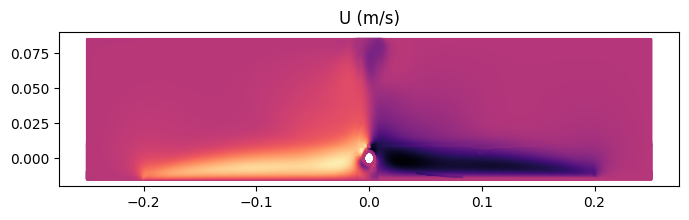

In [5]:
fig, ax = plt.subplots(figsize=(8,2))
ax.scatter(node_x, node_y, c=U, cmap='magma', s=1)
ax.set_title("U (m/s)")

Text(0.5, 1.0, 'V (m/s)')

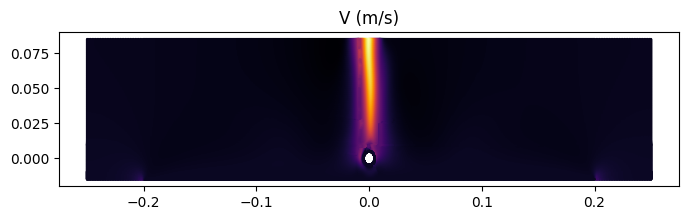

In [6]:
fig, ax = plt.subplots(figsize=(8,2))
ax.scatter(node_x, node_y, c=V, cmap='inferno', s=1)
ax.set_title("V (m/s)")

## Test point querying

In [145]:
def query_point(node_x, node_y, data_file, z, query_x, query_y):
    """Given a set of cell coordinates node_x, node_y, and a list of requested coordinates query_x, query_y,
    obtain the corresponding z values from the entire z array.
    """
    # Convert lists to numpy arrays if they are not already
    query_x = np.array(query_x)
    query_y = np.array(query_y)

    with h5py.File(data_file, "r") as f:
        a = f['/settings/Common/'][:]   
        flowtime = float(a[0].split()[17].decode('utf-8').split('"')[1])
        timestep = float(a[0].split()[14].decode('utf-8').split('"')[1])

    
    # Initialize lists to store results
    results = []
    
    # Tolerances - found with trial and error. 
    tolerance = 1e-4
    rtol = 1e-2
    
    for x, y in zip(query_x, query_y):
        queried_indices = np.where(
            np.isclose(node_x, x, atol=tolerance, rtol=rtol) &
            np.isclose(node_y, y, atol=tolerance, rtol=rtol)
        )
        
        # This will likely return multiple values - this is the result of the 
        # first combination of tolerances that returns nonzero close values.
        # It is assumed that they are close enough in value so that we 
        # can take the average of the values corresponding to the found indices
        close_x = np.nanmean(node_x[queried_indices])
        close_y = np.nanmean(node_y[queried_indices])
        close_z = np.nanmean(z[queried_indices])
        
        results.append((queried_indices, close_x, close_y, close_z, timestep, flowtime))
    
    return results


In [146]:
results = query_point(node_x, node_y, data_files[-1], T, [0.1, 0.005], [-0.01, 0.01])

# This function works for multiple query points. 
for i in results:
    print(i)

((array([200679, 200770, 200771, 200862, 200863, 200954, 200955, 201046,
       201047, 201138, 201139, 201230]),), np.float64(0.09989350768121909), np.float64(-0.009998062689620252), np.float64(306.4273361797147), 32000.0, 1600.0)
((array([142837, 142931, 143025, 143026, 143121, 143122, 143216, 143217,
       143311, 143312]),), np.float64(0.005002653899166811), np.float64(0.00997464189647228), np.float64(308.08206302022234), 32000.0, 1600.0)


Attempt to build a point time series across all post files. 

In [139]:
def get_nodes_from_casefile(data_folder):

    # Find .cas.post files
    case_files = [f for f in os.listdir(data_folder) if f.endswith('.cas.post')]
    
    if case_files:
        fname = os.path.join(data_folder, case_files[0])
        
        # Read the mesh data from the HDF5 file
        with h5py.File(fname, 'r') as f:
            vertex_list = np.transpose(f['/meshes/1.post/nodes/coords/1'][:])
        
        # Extract NodeX and NodeY
        node_x = vertex_list[0]
        node_y = vertex_list[1]
    
        return node_x, node_y

def get_z_for_datafile(data_file):
    # Read temperature and velocity data from the HDF5 file
    with h5py.File(data_file, 'r') as f:
        T = f['/results/1.post/mixture/nodes/Static Temperature/1'][:]
        U = f['/results/1.post/mixture/nodes/X Velocity/1'][:]
        V = f['/results/1.post/mixture/nodes/Y Velocity/1'][:]
    return U, V, T

def get_query_point_from_datafile(node_x, node_y, data_file, query_x, query_y):
    

    _, _, T = get_z_for_datafile(data_file)

    results = query_point(node_x, node_y, data_file, T, query_x, query_y)

    #queried_indices, close_x, close_y, close_u = query_point(node_x, node_y, U, query_x, query_y)
    #queried_indices, close_x, close_y, close_v = query_point(node_x, node_y, V, query_x, query_y)

    return results

    
    

In [147]:
node_x, node_y = get_nodes_from_casefile(data_folder)


query_x = [0.1, 0.005]
query_y = [-0.01, 0.01]

# Test for 1 data file
get_query_point_from_datafile(node_x, node_y, data_files[-1], query_x, query_y)

[((array([200679, 200770, 200771, 200862, 200863, 200954, 200955, 201046,
          201047, 201138, 201139, 201230]),),
  np.float64(0.09989350768121909),
  np.float64(-0.009998062689620252),
  np.float64(302.1351007646268),
  32000.0,
  1600.0),
 ((array([142837, 142931, 143025, 143026, 143121, 143122, 143216, 143217,
          143311, 143312]),),
  np.float64(0.005002653899166811),
  np.float64(0.00997464189647228),
  np.float64(307.435239881175),
  32000.0,
  1600.0)]

In [148]:
from joblib import Parallel, delayed
%env PYTHONWARNINGS=ignore::UserWarning
        
# Use LokyBackend to protect the h5py routine
timeseries_results = Parallel(n_jobs=-1, backend='loky', verbose=1) \
(delayed(get_query_point_from_datafile) \
 (node_x, node_y, data_file, query_x, query_y
 ) for data_file in data_files)

env: PYTHONWARNINGS=ignore::UserWarning


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 804 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 1504 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 2404 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done 3504 tasks      | elapsed:   39.4s
[Parallel(n_jobs=-1)]: Done 4804 tasks      | elapsed:   54.6s
[Parallel(n_jobs=-1)]: Done 6304 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 8004 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 9904 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 12004 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 14304 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 15000 out of 15000 | elapsed:  2.7min finished


In [149]:
# There are 3 dimensions to the results array: (timestep, query point, result data)
timeseries_results_array = np.array(timeseries_results, dtype=object)
queried_x_points = timeseries_results_array[:,:,1]
queried_y_points = timeseries_results_array[:,:,2]
queried_t_points = timeseries_results_array[:,:,3]
queried_timesteps = timeseries_results_array[:,:,4]
queried_flowtimes = timeseries_results_array[:,:,5]

(0.0, 1600.0)

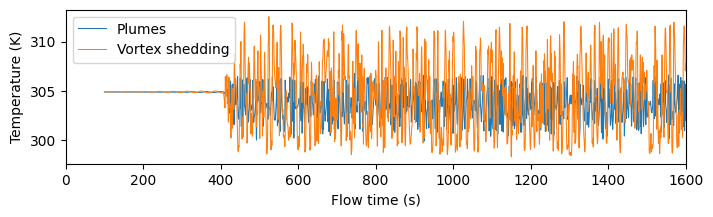

In [156]:
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots(figsize=(8,2))

ax.plot(queried_flowtimes[:,0], queried_t_points[:,0], linewidth=0.75, label="Plumes")
ax.plot(queried_flowtimes[:,1], queried_t_points[:,1], linewidth=0.75, label="Vortex shedding")
ax = plt.gca()  # Get current axis
ax.xaxis.set_major_locator(MaxNLocator(nbins=10)) 

ax.set_xlabel("Flow time (s)")
ax.set_ylabel("Temperature (K)")

ax.legend()

ax.set_xlim([0,1600])

In [164]:
def get_autocorrelation(z):
    # Compute the autocorrelation
    autocorr = np.correlate(z - np.mean(z), z - np.mean(z), mode='full')
    # Take only the 2nd half to get rid of negative lags
    autocorr = autocorr[autocorr.size // 2:]
    autocorr /= autocorr[0]
    return autocorr

start_time = 450
start_index = int(start_time/2/0.05)
transient_t_vortex = queried_t_points[start_index:,1]
transient_t_plume = queried_t_points[start_index:,0]
#vortex_autocorr = get_autocorrelation(transient_t_vortex)
#plume_autocorr = get_autocorrelation(transient_t_plume)

(array([3499, 3499]), array([0, 1]))


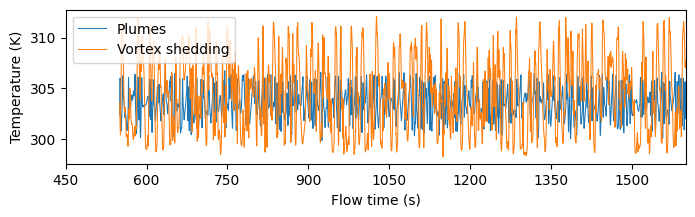

In [170]:
fig, ax = plt.subplots(figsize=(8,2))

start_time = 450
start_index = int(start_time/2/0.05)

ax.plot(queried_flowtimes[start_index:,0], queried_t_points[start_index:,0], linewidth=0.75, label="Plumes")
ax.plot(queried_flowtimes[start_index:,1], queried_t_points[start_index:,1], linewidth=0.75, label="Vortex shedding")
ax = plt.gca()  # Get current axis
ax.xaxis.set_major_locator(MaxNLocator(nbins=10)) 

ax.set_xlabel("Flow time (s)")
ax.set_ylabel("Temperature (K)")

ax.set_xlim([450,1600])

ax.legend()



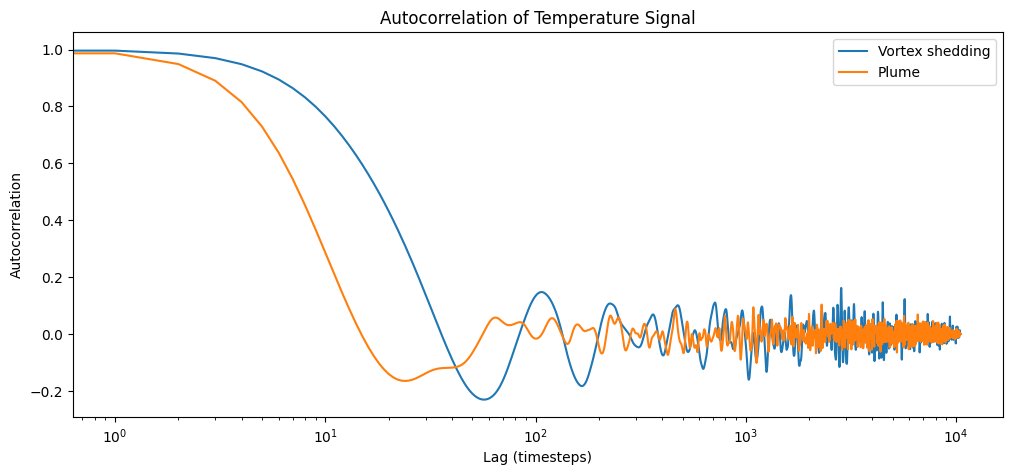

In [167]:
# Plot the autocorrelation
fig, ax = plt.subplots(figsize=(12,5))
#ax.plot(autocorr2)
ax.semilogx(vortex_autocorr, label="Vortex shedding")
ax.semilogx(plume_autocorr, label="Plume")
ax.set_title('Autocorrelation of Temperature Signal')
ax.set_xlabel('Lag (timesteps)')
ax.set_ylabel('Autocorrelation')
ax.legend()